In [245]:
import time
import pandas as pd
import re
import string
import json
from tqdm import tqdm
from langchain_ollama import ChatOllama  # Updated package
import matplotlib.pyplot as plt


In [246]:
def initialize_llm(model_name="llama3.2:3b", temperature=0.1, top_k=100, top_p=0.1, seed=None, mirostat_tau=0.1):
    """
    Initializes the LLM model with the specified parameters.
    """
    seed = seed if seed else int(time.time())  # Use provided seed or generate based on current time
    
    llama = ChatOllama(
        model=model_name,
        format="json",
        temperature=temperature,
        top_k=top_k,
        top_p=top_p,
        seed=seed,
        mirostat_tau=mirostat_tau
    )
    
    return llama


In [247]:
def preprocess_text(text):
    """
    Preprocesses text by converting to lowercase, removing punctuation, and digits.
    """
    text = str(text).lower()  # Convert text to lowercase
    text = text.replace('\n', ' ')  # Replace newlines with spaces
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove digits
    return text


In [248]:
def calculate_risk_score(text, keywords):
    """
    Calculates a risk score based on the number of occurrences of specific keywords in the text.
    """
    # Compile regex pattern from keywords to match any of the high-risk terms in the text
    pattern = re.compile(r'\b(?:' + '|'.join(re.escape(k) for k in keywords) + r')\b')
    return len(re.findall(pattern, text))  # Count the number of keyword matches


In [249]:
def call_llm(llm_model, question):
    """
    Calls the LLM model with a provided question prompt.
    """
    return llm_model.invoke(question)


In [250]:
def call_llm_with_retry(llm_model, prompt, max_retries=3):
    """
    Calls the LLM with retry logic in case of errors such as JSON parsing errors.
    """
    retries = 0
    while retries < max_retries:
        response = call_llm(llm_model, prompt)
        try:
            response_content = response.content
            json_response = json.loads(response_content)  # Attempt to parse the JSON response
            return json_response  # Return parsed JSON
        except (json.JSONDecodeError, AttributeError) as e:
            retries += 1  # Increment retry counter
            print(f"Retry {retries} for prompt due to: {e}")
    return None  # Return None if all retries fail


In [251]:
def process_row(row, risk_keywords, prompt_template, llm_model, risk_threshold):
    """
    Processes a single row of data, calculates the risk score, and if above the threshold, calls the LLM.

    Returns:
    - tuple: (JSON response, LLM status as str, risk_score) or (None, error status, risk_score).
    """
    # Extract relevant data from the row
    point_name = row['PNT_NM']
    qualifier_txt = row['QUALIFIER_TXT']
    atrisk_notes = row['PNT_ATRISKNOTES_TX']
    followup_notes = row['PNT_ATRISKFOLWUPNTS_TX']

    # Handle missing follow-up notes
    if pd.isna(followup_notes):
        followup_notes = "No follow-up notes provided."

    # Preprocess and combine the text fields
    combined_text = preprocess_text(f"{point_name} {qualifier_txt} {atrisk_notes} {followup_notes}")
    risk_score = calculate_risk_score(combined_text, risk_keywords)  # Calculate risk score

    # Check if risk score exceeds the threshold
    if risk_score > risk_threshold:
        # Format the prompt with the preprocessed text
        prompt = prompt_template.format(combined_text=combined_text)

        # Call the LLM with retry logic
        response_content = call_llm_with_retry(llm_model, prompt)
        if response_content is None:
            return None, "LLM Failed", risk_score  # If LLM fails, return failure status along with the risk score

        # Check if response is already a dictionary (valid JSON)
        if isinstance(response_content, dict):
            return response_content, "Success", risk_score  # Return successful response and risk score
        else:
            # Attempt to parse JSON if not already a dictionary
            try:
                json_response = json.loads(response_content)
                return json_response, "Success", risk_score
            except json.JSONDecodeError:
                return None, "JSON Parsing Error", risk_score  # Return parsing error status and risk score
    else:
        return None, "Below Risk Threshold", risk_score  # Return if risk score is below threshold


In [252]:
def process_data(dataframe, prompt_template, risk_keywords, llm_model, risk_threshold=1):
    """
    Processes the entire DataFrame, calls the LLM for rows exceeding the risk threshold, and updates the DataFrame.

    Returns:
    - pd.DataFrame: The updated DataFrame with LLM responses and risk scores.
    - list: A list of failed responses for further investigation.
    """
    # Initialize columns for storing results
    dataframe['RESPONSE'] = None
    dataframe['HIGH_ENERGY'] = None
    dataframe['INCIDENT'] = None
    dataframe['INJURY'] = None
    dataframe['CONTROLS_PRESENT'] = None
    dataframe['SEVERITY_SCORE'] = None
    dataframe['LLM_STATUS'] = None
    dataframe['CONFIDENCE_SCORE'] = None
    dataframe['RISK_SCORE'] = None  # Add risk score column
    failed_responses = []

    # Loop through each row in the DataFrame
    for index, row in tqdm(dataframe.iterrows(), desc="Assembling Prompts", total=len(dataframe), unit="row"):
        # Process the row and get the LLM response
        result, status, risk_score = process_row(row, risk_keywords, prompt_template, llm_model, risk_threshold)

        # Store the risk score in the DataFrame
        dataframe.at[index, 'RISK_SCORE'] = risk_score

        if result:
            # Update DataFrame with LLM results
            dataframe.at[index, 'HIGH_ENERGY'] = result.get("high_energy_present", None)
            dataframe.at[index, 'INCIDENT'] = result.get("high_energy_incident", None)
            dataframe.at[index, 'INJURY'] = result.get("serious_injury_sustained", None)
            dataframe.at[index, 'CONTROLS_PRESENT'] = result.get("direct_controls_present", None)
            dataframe.at[index, 'SEVERITY_SCORE'] = result.get("severity_score", None)
            dataframe.at[index, 'CONFIDENCE_SCORE'] = result.get("confidence_score", None)
        else:
            # Append failed responses for debugging
            failed_responses.append({"index": index, "prompt": row, "error": status})

        dataframe.at[index, 'LLM_STATUS'] = status  # Record LLM status

        # Save progress every 100 rows
        if index % 100 == 0:
            dataframe.to_csv(f"output_partial.csv", index=False)

    return dataframe, failed_responses


In [253]:
def save_output(dataframe, file_name="output_with_llm_json_responses.csv"):
    """
    Saves the updated DataFrame with LLM responses to a CSV file.
    """
    dataframe.to_csv(file_name, index=False)
    print(f"Processing complete. LLM responses saved to {file_name}")


In [254]:
def plot_severity_score_distribution(dataframe):
    """Plot distribution of severity scores."""
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe['SEVERITY_SCORE'].dropna(), bins=range(1, 7), edgecolor='black', alpha=0.7)
    plt.title('Severity Score Distribution', fontsize=16)
    plt.xlabel('Severity Score (1 to 5)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(range(1, 6))  # Severity Score is from 1 to 5
    plt.grid(True)
    plt.show()

In [255]:
def plot_confidence_score_distribution(dataframe):
    """Plot distribution of confidence scores."""
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe['CONFIDENCE_SCORE'].dropna(), bins=10, edgecolor='black', alpha=0.7)
    plt.title('Confidence Score Distribution', fontsize=16)
    plt.xlabel('Confidence Score (0 to 1)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.show()

In [256]:
def plot_high_risk_keyword_distribution(dataframe, risk_keywords):
    """Plot frequency of high-risk keywords."""
    keyword_count = {k: 0 for k in risk_keywords}
    
    # Preprocessing the combined text data and counting keywords
    for _, row in dataframe.iterrows():
        text = preprocess_text(f"{row['PNT_NM']} {row['QUALIFIER_TXT']} {row['PNT_ATRISKNOTES_TX']} {row['PNT_ATRISKFOLWUPNTS_TX']}")
        for keyword in risk_keywords:
            keyword_count[keyword] += text.count(keyword)

    # Create a bar plot for keyword frequency
    plt.figure(figsize=(12, 6))
    plt.bar(keyword_count.keys(), keyword_count.values(), color='royalblue', alpha=0.7)
    plt.title('High-Risk Keyword Frequency', fontsize=16)
    plt.xlabel('Keywords', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True)
    plt.show()

In [257]:
def plot_risk_score_distribution(dataframe, risk_column='RISK_SCORE'):
    """
    Plots the distribution of risk scores in the provided dataframe.

    Parameters:
    - dataframe (pd.DataFrame): The DataFrame containing the risk scores.
    - risk_column (str): The column name in the DataFrame that contains the risk scores. Default is 'RISK_SCORE'.
    """
    # Check if the risk score column exists in the DataFrame
    if risk_column not in dataframe.columns:
        print(f"Error: '{risk_column}' column not found in the DataFrame.")
        return
    
    # Plot the risk score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe[risk_column].dropna(), bins=20, edgecolor='black', alpha=0.7)  # dropna() to remove missing values
    plt.title('Risk Score Distribution', fontsize=16)
    plt.xlabel('Risk Score', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True)
    plt.show()

In [258]:
llm_model = initialize_llm()

In [259]:
# Load dataset
DATA_FILE = r"CORE_HackOhio_subset_cleaned_downsampled.csv"
dataframe = pd.read_csv(DATA_FILE)

In [260]:
# Define prompt template
prompt_template = """
Safety Observation: {combined_text}.
Based on the safety observation provided, please answer the following questions by providing a **valid JSON object**. All answers should be in exact field names and integer values only (1 for Yes, 0 for No). Ensure consistency with the safety guidelines provided below.

JSON format:
{{
"high_energy_present": 1 or 0, 
"high_energy_incident": 1 or 0, 
"serious_injury_sustained": 1 or 0, 
"direct_controls_present": 1 or 0, 
"severity_score": 1 to 5, 
"confidence_score": 0 to 1
}}

Guidelines:
1. **Is high-energy present?**
2. **Was there a high-energy incident?**
3. **Was a serious injury sustained?**
4. **Were direct controls present?**
5. **Provide a severity score** from 1 (low) to 5 (high).
6. **Confidence score** from 0 (low) to 1 (high).
"""

In [261]:
SIF_KEYWORDS = [
    "suspend", "load", "fall", "elevation", "mobile", "equipment", "traffic", "motor", "vehicle", "heavy", 
    "rotating", "equipment", "machine", "mechanical", "temperature", "high", "steam", "fire", "fuel", 
    "explosion", "trench", "excavation", "electrical", "contact", "arc", "flash", "toxic", "chemical", 
    "radiation", "high-energy", "pressure", "unsupported", "soil", "depth", "voltage", "shock", "burn", 
    "third-degree", "burns", "combustion", "IDLH", "oxygen depletion", "pH", "corrosive", "exposure", 
    "crane", "hoist", "lifting", "work zone", "pedestrian", "struck", "vehicle speed", "30 mph"
]

In [239]:
processed_df, failed_responses = process_data(dataframe, prompt_template, SIF_KEYWORDS, llm_model)


Assembling Prompts:  47%|████▋     | 9351/20000 [25:59<29:24,  6.03row/s]  

In [240]:
save_output(processed_df)

Processing complete. LLM responses saved to output_with_llm_json_responses.csv


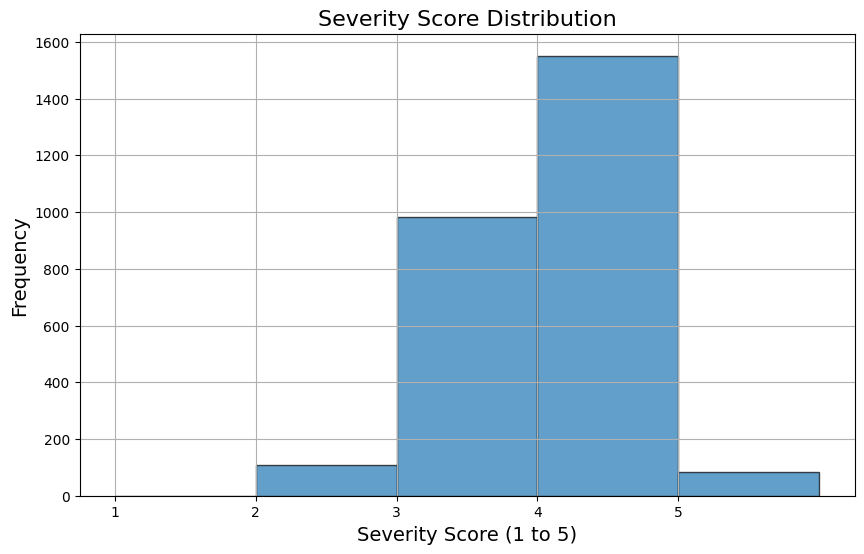

In [241]:
plot_severity_score_distribution(processed_df)

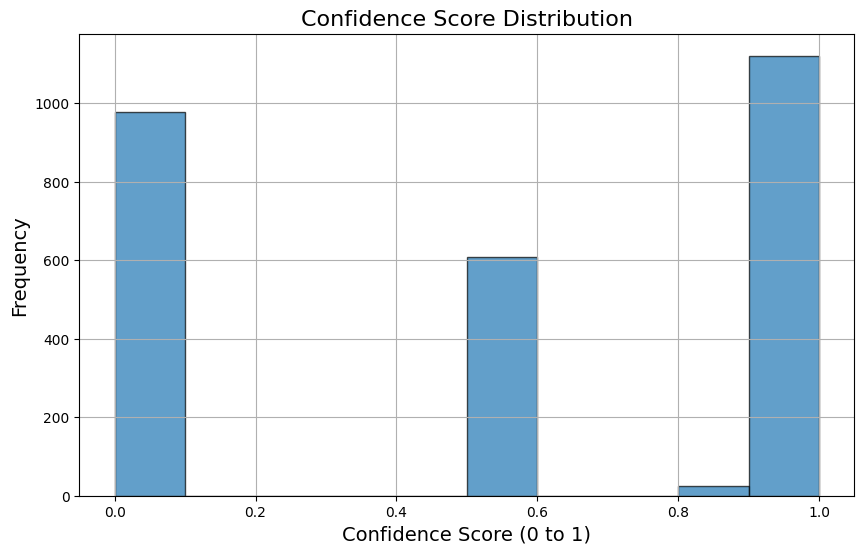

In [242]:
plot_confidence_score_distribution(processed_df)

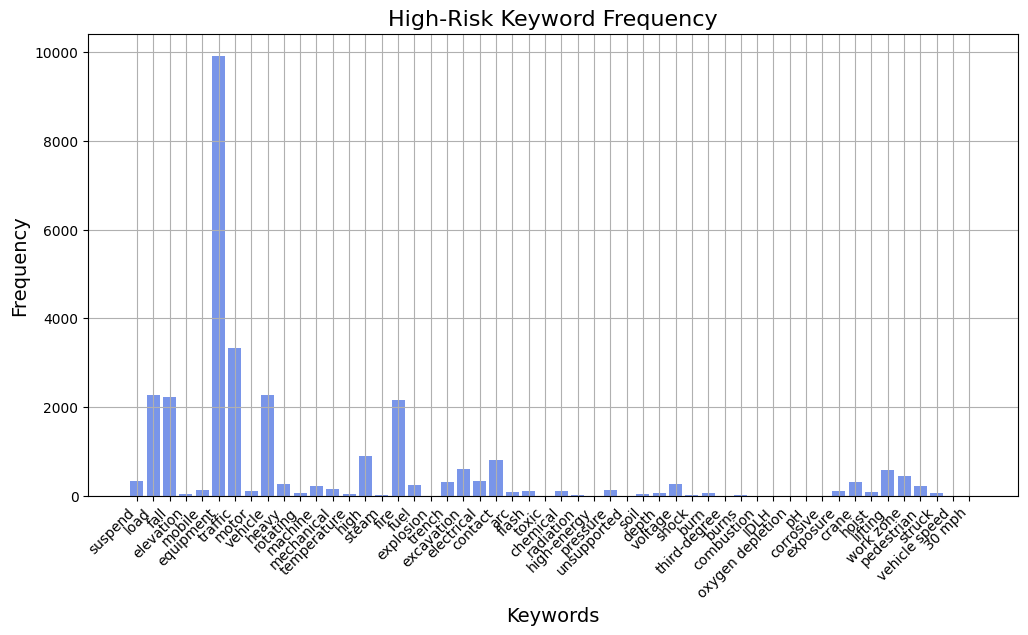

In [243]:
plot_high_risk_keyword_distribution(processed_df, SIF_KEYWORDS)

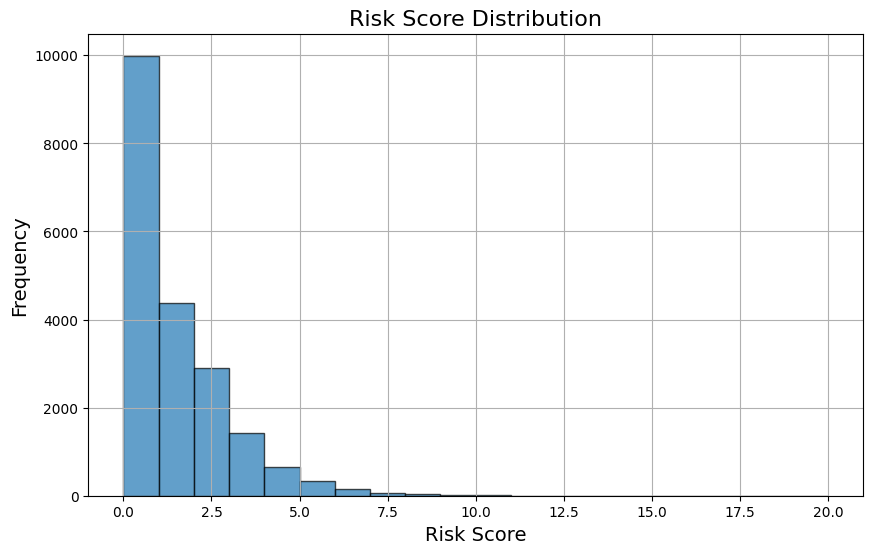

In [244]:
plot_risk_score_distribution(dataframe=dataframe)
